### Code untuk di Jupyter notebook

In [1]:
%cd D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma

D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma


In [2]:
%ls

 Volume in drive D is Data
 Volume Serial Number is BC6D-4CE5

 Directory of D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma

30/11/2021  05:25    <DIR>          .
30/11/2021  05:25    <DIR>          ..
30/11/2021  05:27    <DIR>          logs
22/11/2021  18:54         4.325.824 model_1.h5
22/11/2021  18:54           753.256 model_2.h5
22/11/2021  18:55            23.589 model-1-acc.svg
22/11/2021  18:54            26.334 model-1-loss.svg
22/11/2021  18:54            23.600 model-2-acc.svg
22/11/2021  18:54            26.343 model-2-loss.svg
25/11/2021  17:06    <DIR>          testing
25/11/2021  17:06    <DIR>          training
25/11/2021  17:06    <DIR>          validation
               6 File(s)      5.178.946 bytes
               6 Dir(s)  981.470.486.528 bytes free


In [3]:
import os
# path di jupyter
base_dataset = 'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/'

In [4]:
# inisialisasi direktori data train dan validasi beserta data per kategori
dir1 = [r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/training/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/validation/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/testing/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/training/benign nevi/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/validation/benign nevi/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/testing/benign nevi/']

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1)

val_datagen = ImageDataGenerator(
    rescale=1/255)

test_datagen = ImageDataGenerator(
    rescale=1/255)

In [6]:
batch_size=32
train_dataset = train_datagen.flow_from_directory(batch_size=batch_size,
                                                  directory=base_dataset+'training/',
                                                  target_size=(224, 224),
                                                  class_mode='binary')

validation_dataset = val_datagen.flow_from_directory(batch_size=batch_size,
                                                     directory=base_dataset+'validation/',
                                                     target_size=(224, 224),
                                                     class_mode='binary')
test_dataset = val_datagen.flow_from_directory(batch_size=batch_size,
                                               directory=base_dataset+'testing/',
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 507 images belonging to 2 classes.
Found 145 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

%load_ext tensorboard

In [14]:
%pwd

'D:\\SEMESTER 7\\Pembelajaran Mesin\\Dataset\\preprocess melanoma'

In [15]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [16]:
def scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [17]:
# u/ Melatih / Training data (Model)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,GlobalMaxPool2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from keras.models import load_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

def train_test_model(hparams):
    model = Sequential([
        Input(shape=(224,224,3)),

        Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Flatten(),

        Dense(hparams[HP_NUM_UNITS], activation="relu"),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1, activation='sigmoid')
      ]
    )
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
    callback = EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(train_dataset, batch_size=batch_size,
                            epochs = 50, 
                            validation_data = validation_dataset, callbacks=[lr_schedule, tb_callback,callback])
    _, accuracy = model.evaluate(validation_dataset)
    return accuracy

In [18]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=50)

In [34]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 8s 459ms/step - loss: 7.1464 - accuracy: 0.6410 - val_loss: 5.5092 - val_accuracy: 0.4828
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 323ms/step - loss: 0.7065 - accuracy: 0.5878 - val_loss: 11.1055 - val_accuracy: 0.5172
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 323ms/step - loss: 0.6314 - accuracy: 0.5759 - val_loss: 19.4526 - val_accuracy: 0.5172
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 323ms/step - loss: 0.6640 - accuracy: 0.7101 - val_loss: 22.8983 - val_accuracy: 0.5172
Epoch 5/50



16/16 [==============================] - 6s 355ms/step - loss: 0.2285 - accuracy: 0.9132 - val_loss: 0.7102 - val_accuracy: 0.7379
Epoch 23/50

Epoch 00023: LearningRateScheduler setting learning rate to tf.Tensor(0.0027253162, shape=(), dtype=float32).
16/16 [==============================] - 6s 343ms/step - loss: 0.2229 - accuracy: 0.9073 - val_loss: 0.6506 - val_accuracy: 0.7655
Epoch 24/50

Epoch 00024: LearningRateScheduler setting learning rate to tf.Tensor(0.002465968, shape=(), dtype=float32).
16/16 [==============================] - 6s 348ms/step - loss: 0.2178 - accuracy: 0.9132 - val_loss: 0.5962 - val_accuracy: 0.7586
Epoch 25/50

Epoch 00025: LearningRateScheduler setting learning rate to tf.Tensor(0.0022313, shape=(), dtype=float32).
16/16 [==============================] - 6s 380ms/step - loss: 0.2031 - accuracy: 0.9172 - val_loss: 0.5025 - val_accuracy: 0.8138
Epoch 26/50

Epoch 00026: LearningRateScheduler setting learning rate to tf.Tensor(0.0020189637, shape=(), dtyp

16/16 [==============================] - 6s 361ms/step - loss: 0.9223 - accuracy: 0.6252 - val_loss: 59.0939 - val_accuracy: 0.5172
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 6s 349ms/step - loss: 0.6342 - accuracy: 0.6174 - val_loss: 73.1959 - val_accuracy: 0.5172
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 6s 366ms/step - loss: 0.5715 - accuracy: 0.7101 - val_loss: 79.1628 - val_accuracy: 0.5172
Epoch 7/50

Epoch 00007: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 6s 364ms/step - loss: 0.5434 - accuracy: 0.6943 - val_loss: 80.1482 - val_accuracy: 0.5172
Epoch 8/50

Epoch 00008: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 6s 364ms/step - loss: 0.5395 - accuracy: 0.7041 - v

5/5 [==============================] - 0s 40ms/step - loss: 1.9840 - accuracy: 0.6276
--- Starting trial: run-5
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'sgd'}
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 7s 396ms/step - loss: 2.7278 - accuracy: 0.7002 - val_loss: 1.1075 - val_accuracy: 0.4828
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 6s 380ms/step - loss: 0.5177 - accuracy: 0.7653 - val_loss: 0.6278 - val_accuracy: 0.6207
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 6s 374ms/step - loss: 0.4260 - accuracy: 0.8047 - val_loss: 0.9507 - val_accuracy: 0.5310
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 6s 368ms/step - loss: 0

Epoch 10/50

Epoch 00010: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 6s 383ms/step - loss: 0.3757 - accuracy: 0.8481 - val_loss: 3.9976 - val_accuracy: 0.5172
Epoch 11/50

Epoch 00011: LearningRateScheduler setting learning rate to tf.Tensor(0.009048373, shape=(), dtype=float32).
16/16 [==============================] - 6s 371ms/step - loss: 0.3918 - accuracy: 0.8363 - val_loss: 4.1236 - val_accuracy: 0.5172
Epoch 12/50

Epoch 00012: LearningRateScheduler setting learning rate to tf.Tensor(0.008187306, shape=(), dtype=float32).
16/16 [==============================] - 6s 373ms/step - loss: 0.3565 - accuracy: 0.8501 - val_loss: 3.6901 - val_accuracy: 0.5172
Epoch 13/50

Epoch 00013: LearningRateScheduler setting learning rate to tf.Tensor(0.0074081807, shape=(), dtype=float32).
16/16 [==============================] - 6s 372ms/step - loss: 0.3175 - accuracy: 0.8619 - val_loss: 2.5628 - val_accuracy: 0.5517
Epoch 14/50

E

###### Trial RUN 1 0s 42ms/step - loss: 0.3061 - accuracy: 0.8966 {'num_units': 64, 'dropout': 0.2, 'optimizer': 'sgd'}

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

In [56]:
model = Sequential([
        Input(shape=(224,224,3)),

        Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Flatten(),

        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
      ]
    )

model.summary()

model.compile(
  optimizer=SGD(learning_rate=0.0001),
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

callback = EarlyStopping(
    monitor="val_accuracy",
    patience=30,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(train_dataset, batch_size=batch_size,
                        epochs = 100, 
                        validation_data = validation_dataset, callbacks=[lr_schedule,callback])

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_92 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_93 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 56, 56, 128)     

16/16 [==============================] - 6s 347ms/step - loss: 0.3618 - accuracy: 0.8481 - val_loss: 0.6395 - val_accuracy: 0.6414
Epoch 26/100

Epoch 00026: LearningRateScheduler setting learning rate to tf.Tensor(1.2245627e-05, shape=(), dtype=float32).
16/16 [==============================] - 6s 351ms/step - loss: 0.3759 - accuracy: 0.8363 - val_loss: 0.6060 - val_accuracy: 0.7034
Epoch 27/100

Epoch 00027: LearningRateScheduler setting learning rate to tf.Tensor(1.10803e-05, shape=(), dtype=float32).
16/16 [==============================] - 6s 346ms/step - loss: 0.3803 - accuracy: 0.8343 - val_loss: 0.5761 - val_accuracy: 0.7379
Epoch 28/100

Epoch 00028: LearningRateScheduler setting learning rate to tf.Tensor(1.0025869e-05, shape=(), dtype=float32).
16/16 [==============================] - 6s 351ms/step - loss: 0.3707 - accuracy: 0.8363 - val_loss: 0.5507 - val_accuracy: 0.7724
Epoch 29/100

Epoch 00029: LearningRateScheduler setting learning rate to tf.Tensor(9.071781e-06, shape

16/16 [==============================] - 6s 361ms/step - loss: 0.3595 - accuracy: 0.8363 - val_loss: 0.4137 - val_accuracy: 0.8345
Epoch 58/100

Epoch 00058: LearningRateScheduler setting learning rate to tf.Tensor(4.9915786e-07, shape=(), dtype=float32).
16/16 [==============================] - 6s 356ms/step - loss: 0.3688 - accuracy: 0.8383 - val_loss: 0.4139 - val_accuracy: 0.8345
Epoch 59/100

Epoch 00059: LearningRateScheduler setting learning rate to tf.Tensor(4.516567e-07, shape=(), dtype=float32).
16/16 [==============================] - 6s 360ms/step - loss: 0.3754 - accuracy: 0.8323 - val_loss: 0.4142 - val_accuracy: 0.8345
Epoch 60/100

Epoch 00060: LearningRateScheduler setting learning rate to tf.Tensor(4.0867585e-07, shape=(), dtype=float32).
16/16 [==============================] - 6s 363ms/step - loss: 0.3706 - accuracy: 0.8323 - val_loss: 0.4143 - val_accuracy: 0.8414
Epoch 61/100

Epoch 00061: LearningRateScheduler setting learning rate to tf.Tensor(3.6978517e-07, sha

16/16 [==============================] - 6s 377ms/step - loss: 0.3680 - accuracy: 0.8481 - val_loss: 0.4152 - val_accuracy: 0.8552
Epoch 90/100

Epoch 00090: LearningRateScheduler setting learning rate to tf.Tensor(2.034674e-08, shape=(), dtype=float32).
16/16 [==============================] - 6s 358ms/step - loss: 0.3717 - accuracy: 0.8462 - val_loss: 0.4152 - val_accuracy: 0.8552
Epoch 91/100

Epoch 00091: LearningRateScheduler setting learning rate to tf.Tensor(1.8410491e-08, shape=(), dtype=float32).
16/16 [==============================] - 6s 358ms/step - loss: 0.3546 - accuracy: 0.8264 - val_loss: 0.4152 - val_accuracy: 0.8552
Epoch 92/100

Epoch 00092: LearningRateScheduler setting learning rate to tf.Tensor(1.66585e-08, shape=(), dtype=float32).
16/16 [==============================] - 6s 359ms/step - loss: 0.3722 - accuracy: 0.8343 - val_loss: 0.4153 - val_accuracy: 0.8552
Epoch 93/100

Epoch 00093: LearningRateScheduler setting learning rate to tf.Tensor(1.5073233e-08, shape

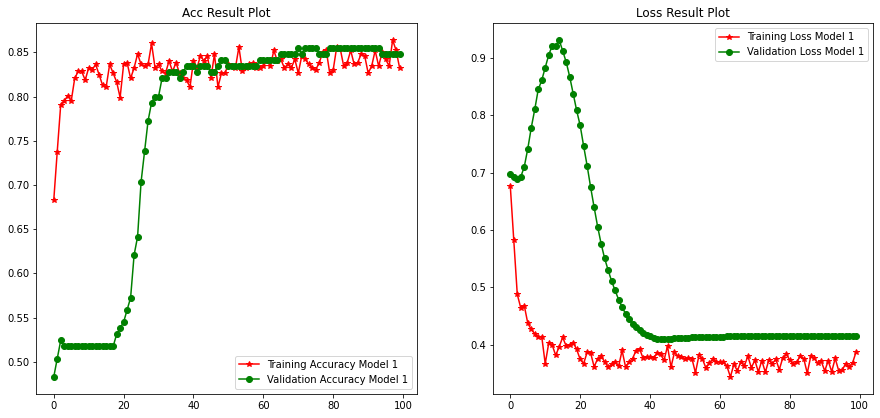

In [57]:
import matplotlib.pyplot as plt

acc_model_1 = history.history['accuracy']
val_acc_model_1 = history.history['val_accuracy']
loss_model_1 = history.history['loss']
val_los_model_1 = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_model_1, label='Training Accuracy Model 1', color='r', marker='*')
plt.plot(epochs_range, val_acc_model_1, label='Validation Accuracy Model 1', color='g', marker='o')
plt.legend(loc='lower right')
plt.title('Acc Result Plot')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_model_1, label='Training Loss Model 1', color='r', marker='*')
plt.plot(epochs_range, val_los_model_1, label='Validation Loss Model 1', color='g', marker='o')
plt.legend(loc='upper right')
plt.title('Loss Result Plot')
plt.show()

In [58]:
result_train = model.evaluate(train_dataset, verbose=1)
print('\n', 'Hasil Akurasi Train:-', result_train[1]," Hasil Loss Train", result_train[0])
result_val = model.evaluate(validation_dataset, verbose=1)
print('\n', 'Hasil Akurasi Val:-', result_val[1]," Hasil Loss Val", result_val[0])
result_test = model.evaluate(test_dataset, verbose=1)
print('\n', 'Hasil Akurasi Test:-', result_test[1]," Hasil Loss Test", result_test[0])

16/16 [==============================] - 5s 301ms/step - loss: 0.3287 - accuracy: 0.8679

 Hasil Akurasi Train:- 0.867850124835968  Hasil Loss Train 0.3286968171596527
5/5 [==============================] - 0s 37ms/step - loss: 0.4149 - accuracy: 0.8483

 Hasil Akurasi Val:- 0.8482758402824402  Hasil Loss Val 0.41491156816482544
3/3 [==============================] - 1s 214ms/step - loss: 0.2969 - accuracy: 0.9028

 Hasil Akurasi Test:- 0.9027777910232544  Hasil Loss Test 0.2968972623348236


In [101]:
melanoma_test_data = [os.path.join(dir1[2], fname) for fname in os.listdir(dir1[2])[:]]
benign_test_data = [os.path.join(dir1[5], fname) for fname in os.listdir(dir1[5])[:]]

In [115]:
import cv2
import numpy as np

def gather_data(dataset_dir, image_size):
    dataset_data = []
    dataset_label = []
    for r, d, f in os.walk(dataset_dir):
        for file in f:
            if ".jpg" in file:
                imagePath = os.path.join(r, file)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (image_size,image_size))
                dataset_data.append(image)
                label = imagePath.split(os.path.sep)[-2]
                dataset_label.append(label)
    dataset_data = np.array(dataset_data)
    dataset_label = np.array(dataset_label)
    return dataset_data, dataset_label

test_data, test_label = gather_data(base_dataset+'testing',224)

In [118]:
from sklearn.preprocessing import LabelEncoder

x_test = test_data.astype('float32') / 255.0

print("Label sebelum di-encoder \n", test_label[:])
lb = LabelEncoder()
y_test = lb.fit_transform(test_label)
print("Label setelah di-encoder \n", y_test[:])

Label sebelum di-encoder 
 ['acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'acral melanoma' 'acral melanoma'
 'acral melanoma' 'acral melanoma' 'benign nevi' 'benign nevi'
 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi'
 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi'
 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi'
 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi'
 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi' 'benign nevi'
 'b

In [123]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred = model.predict(x_test)
labels = (pred > 0.5).astype(int)
target_names = ['acral melanoma', 'benign nevi']
print(classification_report(y_test, labels, target_names=target_names))

print('Confusion Matrix')
print(confusion_matrix(y_test, labels))

                precision    recall  f1-score   support

acral melanoma       0.61      0.97      0.75        34
   benign nevi       0.91      0.32      0.48        31

      accuracy                           0.66        65
     macro avg       0.76      0.65      0.61        65
  weighted avg       0.75      0.66      0.62        65

Confusion Matrix
[[33  1]
 [21 10]]


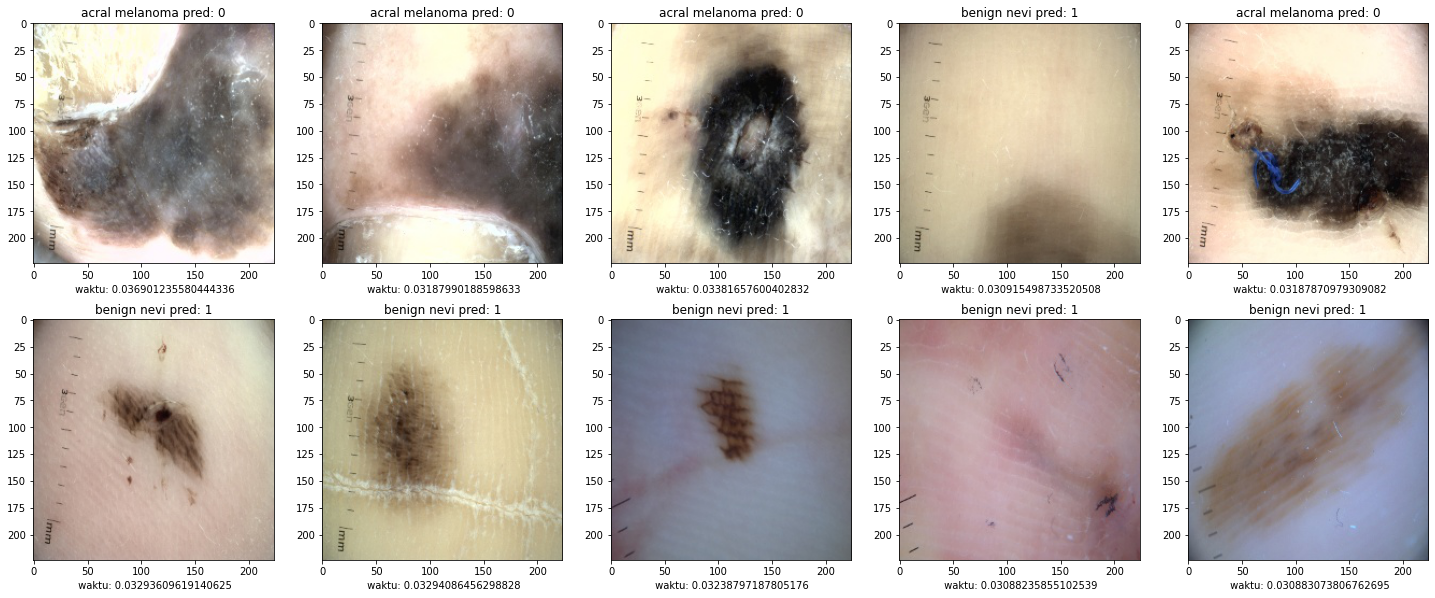

In [129]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from PIL import Image

nrows = 2
ncols = 5
input_size = (224, 224)
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

pic_index += 10
melanoma_pix = [os.path.join(dir1[2], fname) for fname in os.listdir(dir1[2])[0:5]]
benign_pix = [os.path.join(dir1[5], fname) for fname in os.listdir(dir1[5])[0:5]]


def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

for i, img_path in enumerate(melanoma_pix+benign_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)

    labels = ['acral melanoma', 'benign nevi']
    im = Image.open(img_path)
    X = preprocess(im,input_size)
    X = reshape([X])

    start = time.time()
    y = model.predict(X)
    waktu = time.time() - start

    if labels[int(np.round(y, 0))] == 'benign nevi':
        plt.title(labels[int(np.round(y, 0))] + ' pred: '+ str(int(np.round(y, 0))))
        plt.xlabel(' waktu: ' + str(waktu))
    else:
        plt.title(labels[int(np.round(y, 0))] + ' pred: '+ str(int(np.round(y, 0))))
        plt.xlabel(' waktu: ' + str(waktu))
    #sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## HYPERPARAMETER 2

In [37]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [38]:
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [39]:
def train_test_model2(hparams):
    model = Sequential([
        Input(shape=(224,224,3)),

        Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),
        
        Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),

        Flatten(),

        Dense(hparams[HP_NUM_UNITS], activation="relu"),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1, activation='sigmoid')
      ]
    )
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
    callback = EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(train_dataset, batch_size=batch_size,
                            epochs = 50, 
                            validation_data = validation_dataset, callbacks=[lr_schedule, tb_callback,callback])
    _, accuracy = model.evaluate(validation_dataset)
    return accuracy

In [40]:
def run2(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model2(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=50)

In [41]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run2('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 7s 363ms/step - loss: 2.2207 - accuracy: 0.7101 - val_loss: 2.5558 - val_accuracy: 0.4759
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 319ms/step - loss: 0.6223 - accuracy: 0.7850 - val_loss: 2.8499 - val_accuracy: 0.5172
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 323ms/step - loss: 0.3783 - accuracy: 0.8363 - val_loss: 9.1558 - val_accuracy: 0.5172
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 321ms/step - loss: 0.3454 - accuracy: 0.8363 - val_loss: 13.1931 - val_accuracy: 0.5172
Epoch 5/50

E

16/16 [==============================] - 5s 327ms/step - loss: 0.1086 - accuracy: 0.9645 - val_loss: 0.5340 - val_accuracy: 0.8483
Epoch 34/50

Epoch 00034: LearningRateScheduler setting learning rate to tf.Tensor(5.502313e-05, shape=(), dtype=float32).
16/16 [==============================] - 5s 333ms/step - loss: 0.1238 - accuracy: 0.9546 - val_loss: 0.5132 - val_accuracy: 0.8483
Epoch 35/50

Epoch 00035: LearningRateScheduler setting learning rate to tf.Tensor(4.9786984e-05, shape=(), dtype=float32).
16/16 [==============================] - 5s 331ms/step - loss: 0.0972 - accuracy: 0.9744 - val_loss: 0.4946 - val_accuracy: 0.8483
Epoch 36/50

Epoch 00036: LearningRateScheduler setting learning rate to tf.Tensor(4.5049124e-05, shape=(), dtype=float32).
16/16 [==============================] - 5s 331ms/step - loss: 0.0951 - accuracy: 0.9684 - val_loss: 0.4697 - val_accuracy: 0.8690
Epoch 37/50

Epoch 00037: LearningRateScheduler setting learning rate to tf.Tensor(4.076213e-05, shape=()

Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 338ms/step - loss: 0.5107 - accuracy: 0.8028 - val_loss: 6.8325 - val_accuracy: 0.5172
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 335ms/step - loss: 0.4366 - accuracy: 0.8284 - val_loss: 7.8011 - val_accuracy: 0.5172
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 [==============================] - 5s 335ms/step - loss: 0.3877 - accuracy: 0.8422 - val_loss: 8.5116 - val_accuracy: 0.5172
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
16/16 [==============================] - 5s 339ms/step - loss: 0.3046 - accuracy: 0.8698 - val_loss: 8.0984 - val_accuracy: 0.5172
Epoch 7/50

Epoch 00007: LearningRateScheduler setting learning rate 

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 6s 348ms/step - loss: 1.0469 - accuracy: 0.7041 - val_loss: 0.6874 - val_accuracy: 0.4828
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 5s 335ms/step - loss: 0.4645 - accuracy: 0.7988 - val_loss: 0.6780 - val_accuracy: 0.5310
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 5s 331ms/step - loss: 0.3885 - accuracy: 0.8402 - val_loss: 0.6603 - val_accuracy: 0.5448
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 [==============================] - 5s 331ms/step - loss: 0.3671 - accuracy: 0.8600 - val_loss: 0.6969 - val_accuracy: 0.5172
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.009999999776482582.
16/16 

16/16 [==============================] - 6s 341ms/step - loss: 0.2534 - accuracy: 0.8856 - val_loss: 1.0454 - val_accuracy: 0.5172
Epoch 10/50

Epoch 00010: LearningRateScheduler setting learning rate to tf.Tensor(0.006065305, shape=(), dtype=float32).
16/16 [==============================] - 5s 335ms/step - loss: 0.2734 - accuracy: 0.8895 - val_loss: 1.0381 - val_accuracy: 0.5172
Epoch 11/50

Epoch 00011: LearningRateScheduler setting learning rate to tf.Tensor(0.0054881144, shape=(), dtype=float32).
16/16 [==============================] - 5s 331ms/step - loss: 0.2196 - accuracy: 0.9093 - val_loss: 0.9156 - val_accuracy: 0.5172
Epoch 12/50

Epoch 00012: LearningRateScheduler setting learning rate to tf.Tensor(0.004965851, shape=(), dtype=float32).
16/16 [==============================] - 5s 333ms/step - loss: 0.2422 - accuracy: 0.8935 - val_loss: 1.1288 - val_accuracy: 0.5172
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
5/5 [====================

###### {'num_units': 256, 'dropout': 0.1, 'optimizer': 'adam'} RUN - 0

In [76]:
model2 = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Flatten(),

    Dense(256, activation="relu"),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
  ]
)

model2.summary()

model2.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

callback = EarlyStopping(
    monitor="val_accuracy",
    patience=30,
    verbose=1,
    restore_best_weights=True,
)
history2 = model2.fit(train_dataset, batch_size=batch_size,
                        epochs = 100, 
                        validation_data = validation_dataset, callbacks=[lr_schedule,callback])

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_95 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_96 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 56, 56, 64)      

Epoch 24/100

Epoch 00024: LearningRateScheduler setting learning rate to tf.Tensor(0.00014956844, shape=(), dtype=float32).
16/16 [==============================] - 6s 354ms/step - loss: 0.1625 - accuracy: 0.9389 - val_loss: 1.3075 - val_accuracy: 0.6828
Epoch 25/100

Epoch 00025: LearningRateScheduler setting learning rate to tf.Tensor(0.00013533511, shape=(), dtype=float32).
16/16 [==============================] - 6s 340ms/step - loss: 0.1548 - accuracy: 0.9428 - val_loss: 1.1337 - val_accuracy: 0.7241
Epoch 26/100

Epoch 00026: LearningRateScheduler setting learning rate to tf.Tensor(0.00012245627, shape=(), dtype=float32).
16/16 [==============================] - 5s 330ms/step - loss: 0.1648 - accuracy: 0.9310 - val_loss: 0.9397 - val_accuracy: 0.7655
Epoch 27/100

Epoch 00027: LearningRateScheduler setting learning rate to tf.Tensor(0.00011080301, shape=(), dtype=float32).
16/16 [==============================] - 5s 330ms/step - loss: 0.1574 - accuracy: 0.9349 - val_loss: 0.8332

16/16 [==============================] - 5s 337ms/step - loss: 0.1096 - accuracy: 0.9566 - val_loss: 0.5320 - val_accuracy: 0.8690
Epoch 57/100

Epoch 00057: LearningRateScheduler setting learning rate to tf.Tensor(5.5165483e-06, shape=(), dtype=float32).
16/16 [==============================] - 5s 334ms/step - loss: 0.1171 - accuracy: 0.9606 - val_loss: 0.5276 - val_accuracy: 0.8690
Epoch 58/100

Epoch 00058: LearningRateScheduler setting learning rate to tf.Tensor(4.991579e-06, shape=(), dtype=float32).
16/16 [==============================] - 5s 339ms/step - loss: 0.1023 - accuracy: 0.9665 - val_loss: 0.5306 - val_accuracy: 0.8690
Epoch 59/100

Epoch 00059: LearningRateScheduler setting learning rate to tf.Tensor(4.516567e-06, shape=(), dtype=float32).
16/16 [==============================] - 5s 337ms/step - loss: 0.1034 - accuracy: 0.9645 - val_loss: 0.5365 - val_accuracy: 0.8690
Epoch 60/100

Epoch 00060: LearningRateScheduler setting learning rate to tf.Tensor(4.0867585e-06, shap

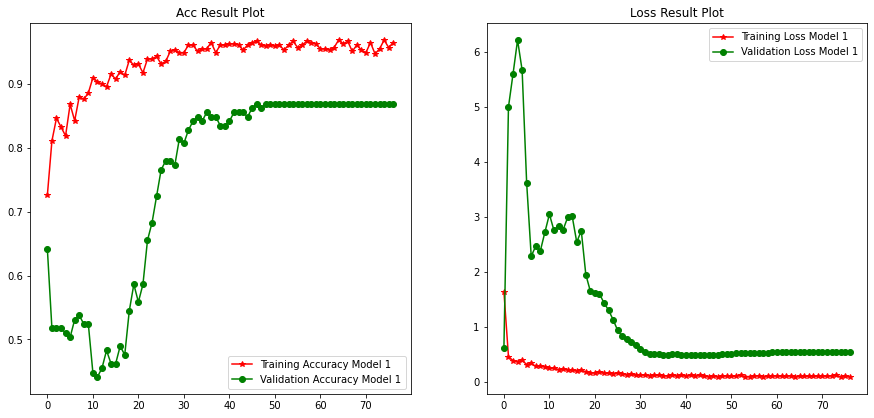

In [77]:
import matplotlib.pyplot as plt

acc_model_2 = history2.history['accuracy']
val_acc_model_2 = history2.history['val_accuracy']
loss_model_2 = history2.history['loss']
val_los_model_2 = history2.history['val_loss']

epochs_range = range(77)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_model_2, label='Training Accuracy Model 1', color='r', marker='*')
plt.plot(epochs_range, val_acc_model_2, label='Validation Accuracy Model 1', color='g', marker='o')
plt.legend(loc='lower right')
plt.title('Acc Result Plot')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_model_2, label='Training Loss Model 1', color='r', marker='*')
plt.plot(epochs_range, val_los_model_2, label='Validation Loss Model 1', color='g', marker='o')
plt.legend(loc='upper right')
plt.title('Loss Result Plot')
plt.show()

In [78]:
result_train = model2.evaluate(train_dataset, verbose=1)
print('\n', 'Hasil Akurasi Train:-', result_train[1]," Hasil Loss Train", result_train[0])
result_val = model2.evaluate(validation_dataset, verbose=1)
print('\n', 'Hasil Akurasi Val:-', result_val[1]," Hasil Loss Val", result_val[0])
result_test = model2.evaluate(test_dataset, verbose=1)
print('\n', 'Hasil Akurasi Test:-', result_test[1]," Hasil Loss Test", result_test[0])

16/16 [==============================] - 5s 305ms/step - loss: 0.1168 - accuracy: 0.9606

 Hasil Akurasi Train:- 0.9605522751808167  Hasil Loss Train 0.11676452308893204
5/5 [==============================] - 0s 37ms/step - loss: 0.4995 - accuracy: 0.8690

 Hasil Akurasi Val:- 0.8689655065536499  Hasil Loss Val 0.4995141327381134
3/3 [==============================] - 0s 110ms/step - loss: 0.1462 - accuracy: 0.9444

 Hasil Akurasi Test:- 0.9444444179534912  Hasil Loss Test 0.14615283906459808


In [131]:
pred = model2.predict(x_test)
labels = (pred > 0.5).astype(int)
target_names = ['acral melanoma', 'benign nevi']
print(classification_report(y_test, labels, target_names=target_names))

print('Confusion Matrix')
print(confusion_matrix(y_test, labels))

                precision    recall  f1-score   support

acral melanoma       0.75      0.88      0.81        34
   benign nevi       0.84      0.68      0.75        31

      accuracy                           0.78        65
     macro avg       0.79      0.78      0.78        65
  weighted avg       0.79      0.78      0.78        65

Confusion Matrix
[[30  4]
 [10 21]]


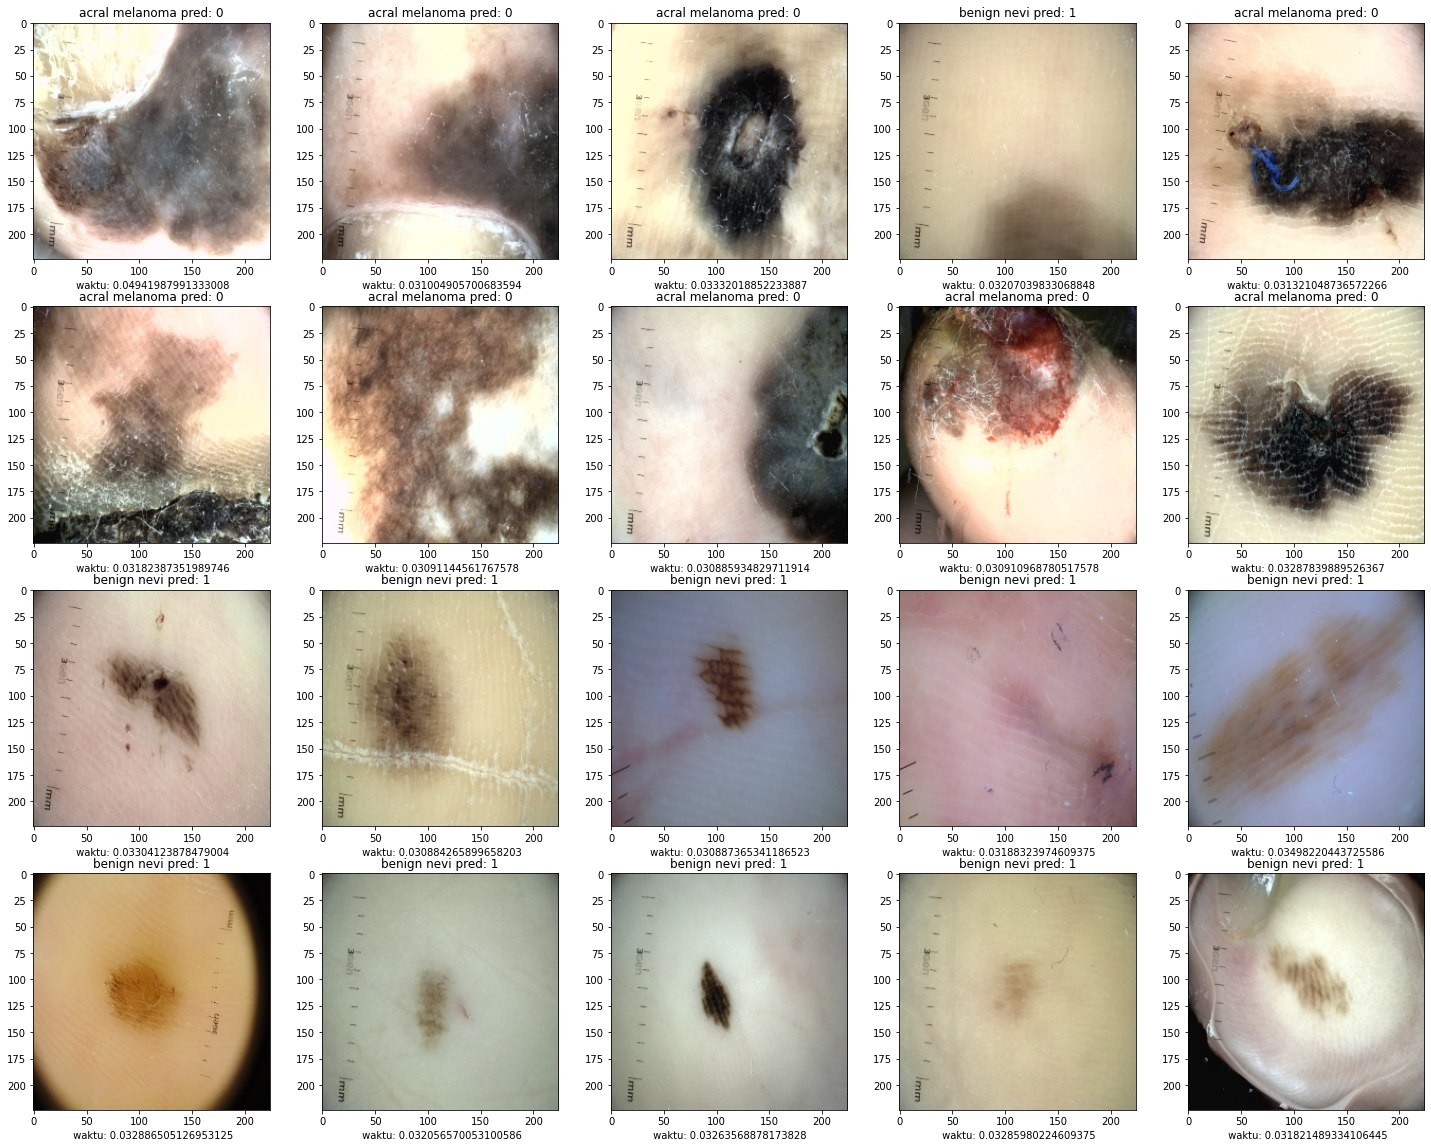

In [136]:
nrows = 4
ncols = 5
input_size = (224, 224)
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

pic_index += 20
melanoma_pix = [os.path.join(dir1[2], fname) for fname in os.listdir(dir1[2])[:10]]
benign_pix = [os.path.join(dir1[5], fname) for fname in os.listdir(dir1[5])[:10]]

for i, img_path in enumerate(melanoma_pix+benign_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)

    labels = ['acral melanoma', 'benign nevi']
    im = Image.open(img_path)
    X = preprocess(im,input_size)
    X = reshape([X])

    start = time.time()
    y = model2.predict(X)
    waktu = time.time() - start

    if labels[int(np.round(y, 0))] == 'benign nevi':
        plt.title(labels[int(np.round(y, 0))] + ' pred: '+ str(int(np.round(y, 0))))
        plt.xlabel(' waktu: ' + str(waktu))
    else:
        plt.title(labels[int(np.round(y, 0))] + ' pred: '+ str(int(np.round(y, 0))))
        plt.xlabel(' waktu: ' + str(waktu))
    #sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [49]:
%tensorboard --logdir=logs/hparam_tuning --host localhost --port 9090

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
model_1 = Sequential()

model_1.add(InputLayer(input_shape=[224,224,3]))
model_1.add(Conv2D(32, (3,3), strides=2, padding='same', activation='relu'))
model_1.add(MaxPool2D(2, 2, padding='same'))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(64, (3,3), strides=2, padding='same', activation='relu'))
model_1.add(MaxPool2D(2, 2, padding='same'))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
model_1.add(MaxPool2D(2, 2, padding='same'))
model_1.add(Dropout(0.2))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

In [ ]:
model_1.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
history_model_1 = model_1.fit(train_dataset, epochs = 100, steps_per_epoch = 580//batch_size, validation_steps = 144//batch_size ,validation_data=validation_dataset)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
plt.plot(np.arange(0, 100), history_model_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history_model_1.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.style.use("ggplot")
plt.plot(np.arange(0, 100), history_model_1.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), history_model_1.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
model_1.save('model_1-fix.h5')

In [ ]:
model_2 = Sequential()

model_2.add(InputLayer(input_shape=[224,224,3]))
model_2.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
model_2.add(MaxPool2D(pool_size=2, padding='same'))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'))
model_2.add(MaxPool2D(pool_size=2, padding='same'))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'))
model_2.add(MaxPool2D(pool_size=2, padding='same'))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

In [ ]:
model_2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
history_model_2 = model_2.fit(train_dataset, epochs = 100, steps_per_epoch = 580//batch_size, validation_steps = 144//batch_size ,validation_data=validation_dataset)

In [ ]:
plt.style.use("ggplot")
plt.plot(np.arange(0, 100), history_model_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history_model_1.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.style.use("ggplot")
plt.plot(np.arange(0, 100), history_model_2.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), history_model_2.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
model_2.save('model_2-fix.h5')

In [ ]:
%cd C:\Users\Fadhlan\Pembelajaran Mesin

In [ ]:
model_3 = Sequential()

model_3.add(InputLayer(input_shape=[224,224,3]))
model_3.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'))
model_3.add(MaxPool2D(pool_size=2, padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'))
model_3.add(MaxPool2D(pool_size=2, padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
model_3.add(MaxPool2D(pool_size=2, padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'))
model_3.add(MaxPool2D(pool_size=2, padding='same'))
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(3200, activation='relu'))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

In [ ]:
model_3.compile(optimizer=SGD(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['acc'])
train_step_size = train_dataset.n // train_dataset.batch_size
val_step_size = validation_dataset.n // validation_dataset.batch_size
history_model_3 = model_3.fit(train_dataset, epochs = 100, steps_per_epoch = train_step_size, validation_steps = val_step_size ,validation_data=validation_dataset)

In [ ]:
result_train = model_3.evaluate(train_dataset, verbose=1)
print('\n', 'Hasil Akurasi Train:-', result_train[1]," Hasil Loss Train", result_train[0])
result_val = model_3.evaluate(validation_dataset, verbose=1)
print('\n', 'Hasil Akurasi Val:-', result_val[1]," Hasil Loss Val", result_val[0])
result_test = model_3.evaluate(test_dataset, verbose=1)
print('\n', 'Hasil Akurasi Test:-', result_test[1]," Hasil Loss Test", result_test[0])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true_test = test_dataset.classes
y_pred = np.round(model_3.predict(test_dataset),0)
y_pred=np.argmax(y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_true_test, y_pred))

In [ ]:
print('Classification Report')

target_names = ['acral melanoma', 'benign nevi']
print(classification_report(y_true_test, y_pred, target_names=target_names, zero_division=1))